# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer

random_state = 42

# Reading

In [2]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df['CustID'] = df['CustID'].astype('int')
df = df.set_index('CustID')

# Data Preparation

## Fix EducDeg column value

In [3]:
def educDegtransform(row):
    row = row.decode("utf-8") if type(row) == bytes else row 
    if type(row) == str:
        educ_dict = {
            '1 - Basic': 1,
            '2 - High School': 2,
            '3 - BSc/MSc': 3,
            '4 - PhD': 4
        }
        return educ_dict[row]
    else:
        return row

df['EducDeg'] = df['EducDeg'].apply(lambda row: educDegtransform(row)) 

## Duplicated Values

In [4]:
print("Duplicated rows: ", df[df.duplicated(keep='first')].shape[0])
df = df[~df.duplicated(keep='first')]

Duplicated rows:  3


## Coherence Check

In [5]:
def print_metrics(data, column, name):
    print(f"{name} Mode: {data[column].mode()[0]}")
    print(f"{name} Median: {data[column].median()}")
    print(f"{name} Mean: {data[column].mean():.2f}")
    print(f"{name} Std: {data[column].std():.2f}")
    return

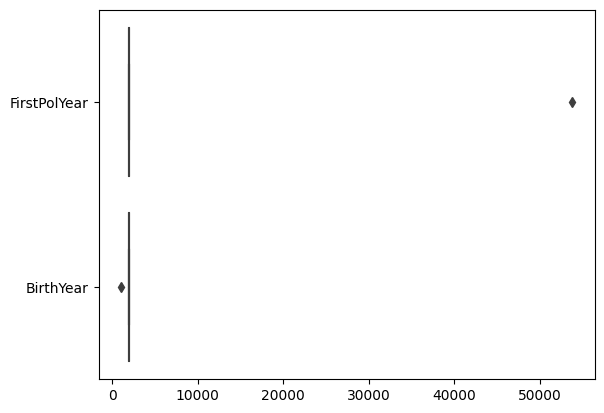

In [6]:
sns.boxplot(data=df[['FirstPolYear', 'BirthYear']], 
orient="h", 
palette="mako")
plt.show()

In [7]:
print('Outlier BirthYear', df['BirthYear'].min())
print('Outlier FirstPolYear', df['FirstPolYear'].max())

Outlier BirthYear 1028.0
Outlier FirstPolYear 53784.0


In [8]:
df = df[df['BirthYear'] != 1028]
df = df[df['FirstPolYear'] != 53784] #Removes the outlier value 

### BirthYear and FirstPolYear

In [9]:
print(f"People who were born after taking out insurance are {(((df[(df['FirstPolYear'] - df['BirthYear']) < 0].shape[0])/df.shape[0])*100):.2f}%")

People who were born after taking out insurance are 19.41%


In [10]:
print("Underage people who has insurance:", df[((2016 - df['BirthYear']) >= 15)&((2016 - df['BirthYear']) < 18)].shape[0])

Underage people who has insurance: 116


## Tratamento Outliers

### Univariate

In [11]:
def apply_limits_sup_inf(data, column, limits):
    
    def limit_apply(row, inf_limit, sup_limit):
        if row > sup_limit:
            return sup_limit
        elif row < inf_limit:
            return inf_limit
        else:
            return row

    if not limits:
        inf_lim = data[column].mean() - 3*data[column].std()
        sup_lim = data[column].mean() + 3*data[column].std()
    else:
        inf_lim = limits[0]
        sup_lim = limits[1]

    return data[column].apply(lambda row: limit_apply(row, inf_lim, sup_lim))

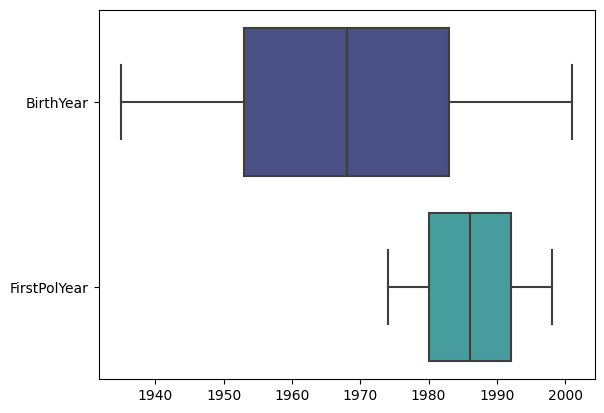

In [12]:
sns.boxplot(data=df[['BirthYear', 'FirstPolYear']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

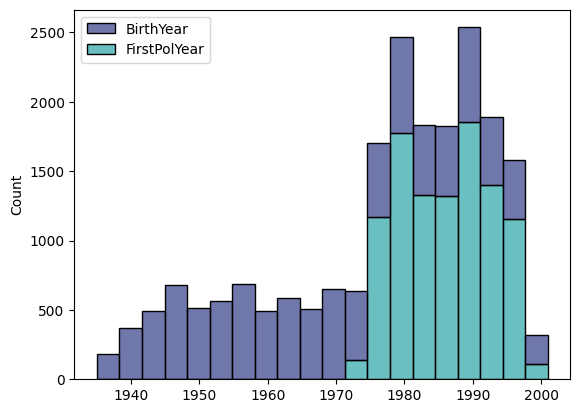

In [13]:
sns.histplot(data=df[['BirthYear', 'FirstPolYear']], bins=20, palette="mako", multiple="stack")
plt.show()

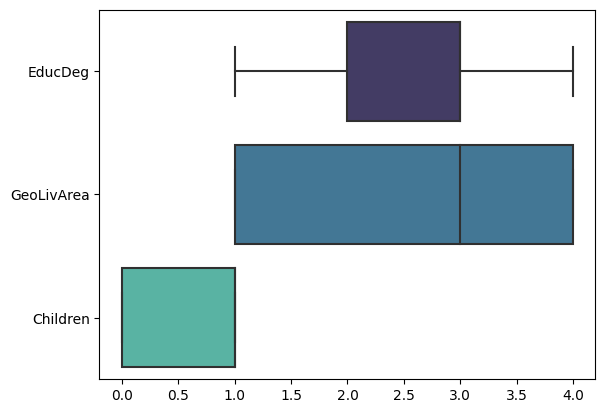

In [14]:
sns.boxplot(data=df[['EducDeg', 'GeoLivArea', 'Children']], 
orient="h", 
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

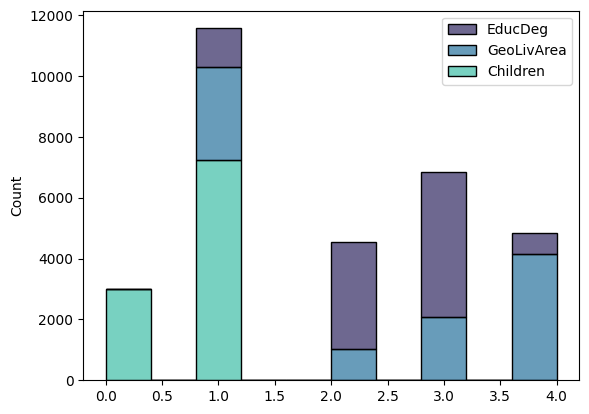

In [15]:
sns.histplot(data=df[['EducDeg', 'GeoLivArea', 'Children']], bins=10, palette="mako", multiple="stack")
plt.show()

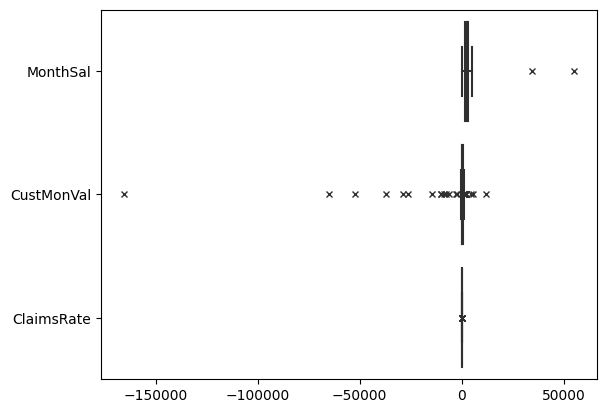

In [16]:
sns.boxplot(data=df[['MonthSal', 'CustMonVal', 'ClaimsRate']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

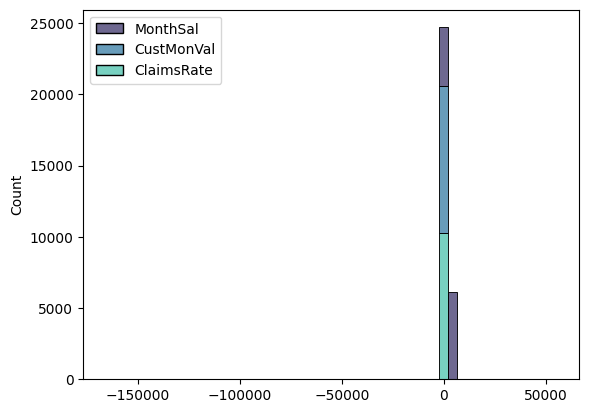

In [17]:
sns.histplot(data=df[['MonthSal', 'CustMonVal', 'ClaimsRate']], bins=50, palette="mako", multiple="stack")
plt.show()

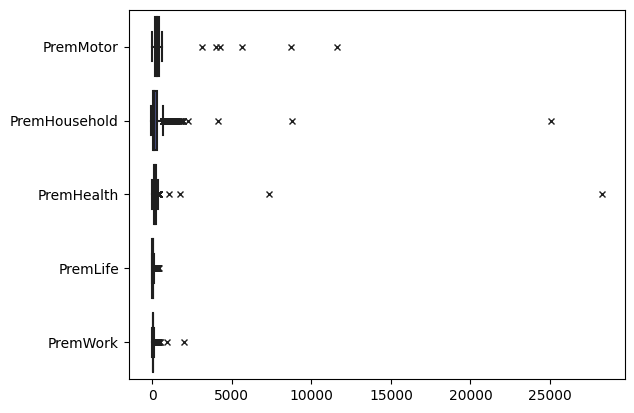

In [18]:
sns.boxplot(data=df[['PremMotor', 'PremHousehold','PremHealth', 'PremLife', 'PremWork']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

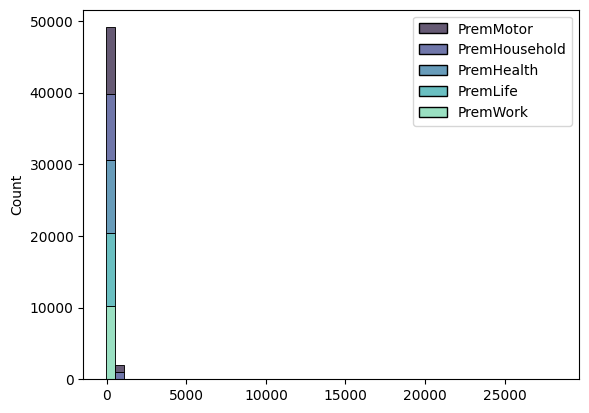

In [19]:
sns.histplot(data=df[['PremMotor', 'PremHousehold','PremHealth', 'PremLife', 'PremWork']], bins=50, palette="mako", multiple="stack")
plt.show()

#### MonthSal

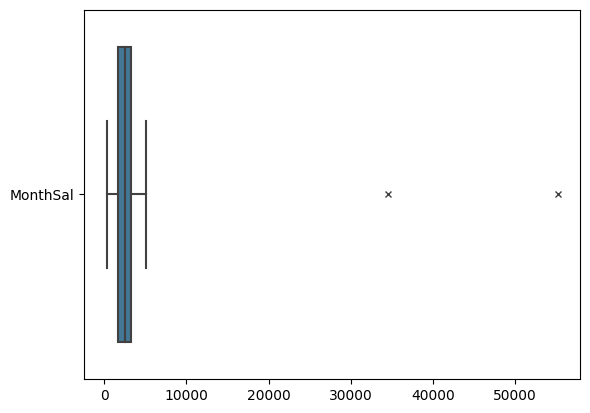

In [20]:
sns.boxplot(data=df[['MonthSal']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

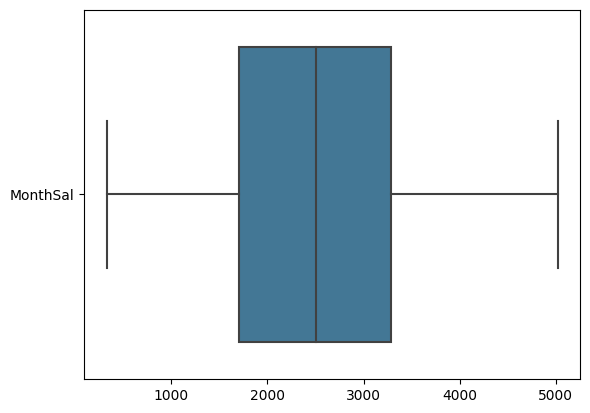

In [21]:
sns.boxplot(data=df[df['MonthSal'] < 10000][['MonthSal']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

In [22]:
df = df[df['MonthSal'] < 10000]

#### CustMonVal

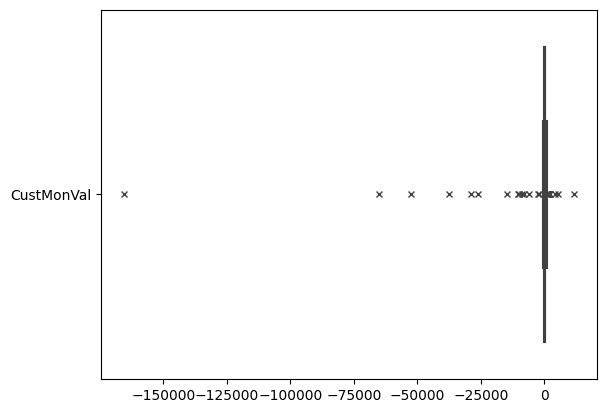

In [23]:
sns.boxplot(data=df[['CustMonVal']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show()

<AxesSubplot:>

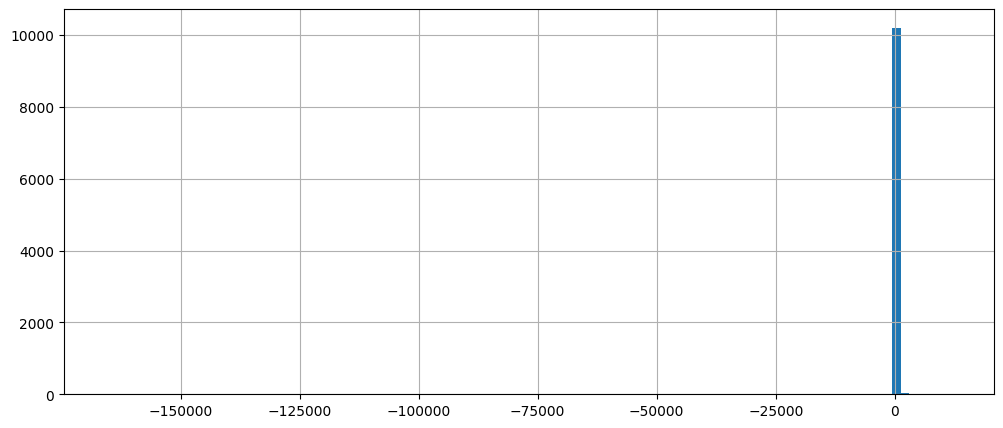

In [24]:
df['CustMonVal'].hist(bins=100, figsize=(12,5))

In [25]:
def return_tuple_max_min(data, column):
    return (data[column].min(), data[column].max())

In [26]:
print("CustMonVal outliers: ", (df[~((-500<df['CustMonVal'])&(df['CustMonVal']<=1000))]).shape[0])
df_CustMonVal = df[((-500<=df['CustMonVal'])&(df['CustMonVal']<=1000))].copy()
CMV_limits = return_tuple_max_min(df_CustMonVal, 'CustMonVal')
df['CustMonVal'] = apply_limits_sup_inf(df, 'CustMonVal', CMV_limits)

CustMonVal outliers:  115


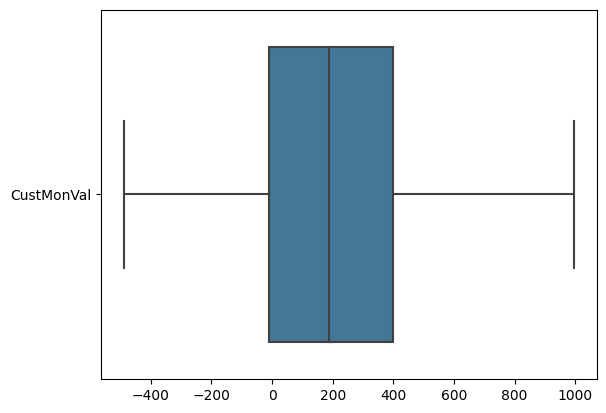

In [27]:
sns.boxplot(data=df[['CustMonVal']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

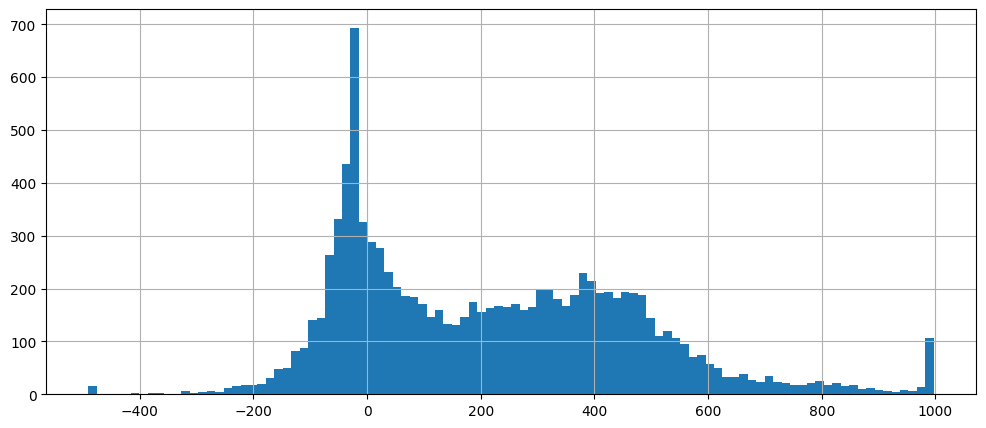

In [28]:
df['CustMonVal'].hist(bins=100, figsize=(12,5))

#### ClaimsRate

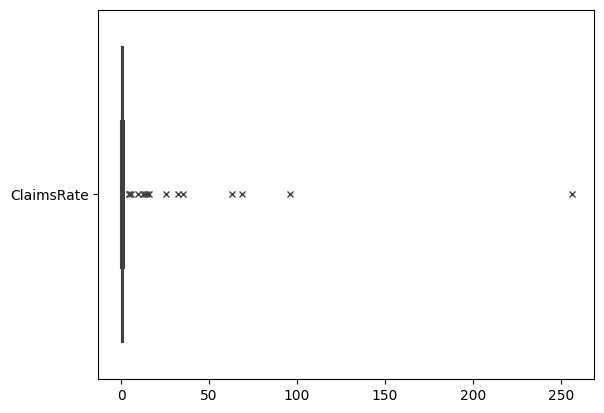

In [29]:
sns.boxplot(data=df[['ClaimsRate']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

In [30]:
print("ClaimsRate outliers ", df[df['ClaimsRate'] > 4].shape[0])
df_ClaimsRate = df[df['ClaimsRate'] < 4].copy()
ClaimsRate_limits = return_tuple_max_min(df_ClaimsRate, 'ClaimsRate')
df['ClaimsRate'] = apply_limits_sup_inf(df, 'ClaimsRate', ClaimsRate_limits)

ClaimsRate outliers  15


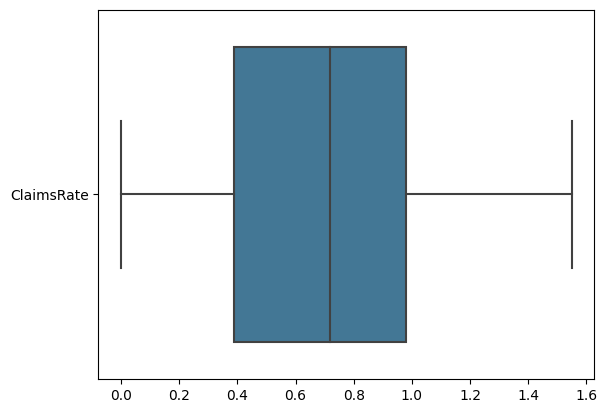

In [31]:
sns.boxplot(data=df[['ClaimsRate']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

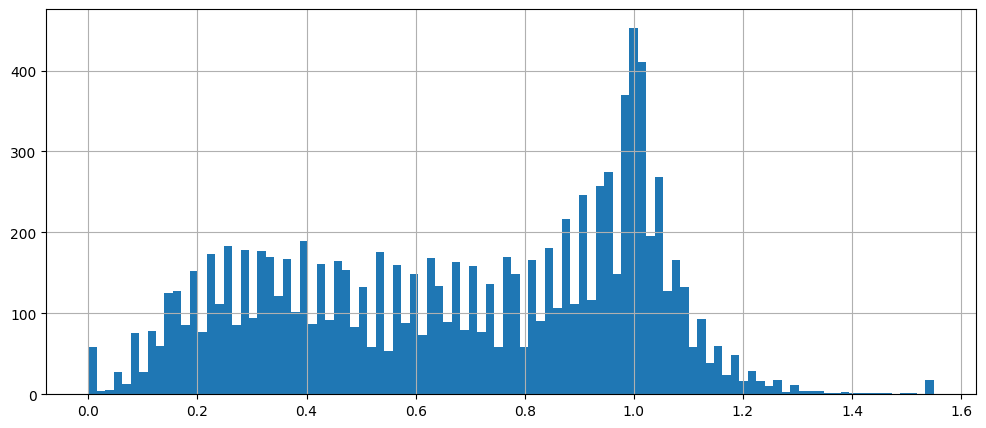

In [32]:
df['ClaimsRate'].hist(bins=100, figsize=(12,5))

#### PremMotor

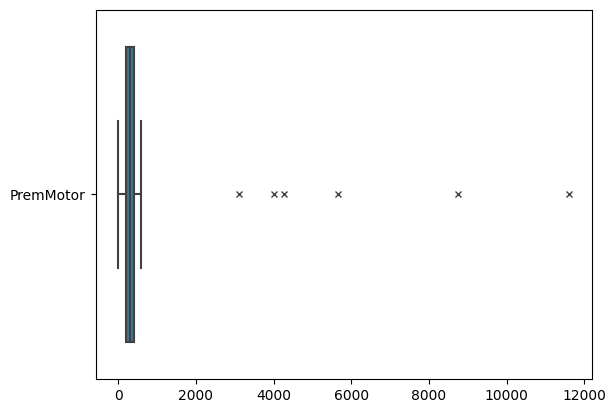

In [33]:
sns.boxplot(data=df[['PremMotor']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

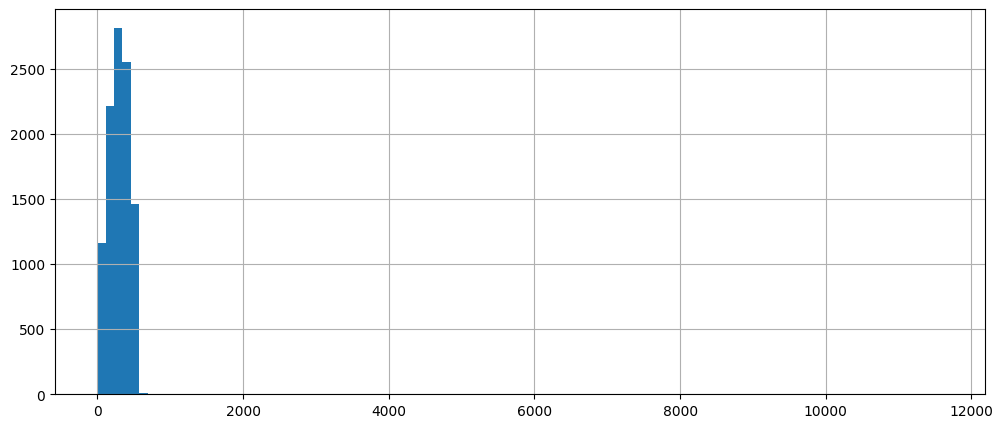

In [34]:
df['PremMotor'].hist(bins=100, figsize=(12,5))

In [35]:
print("PremMotor outliers ", df[df['PremMotor'] > 2000].shape[0])
df_PremMotor = df[df['PremMotor'] < 2000].copy()
PremMotor_limits = return_tuple_max_min(df_PremMotor, 'PremMotor')
df['PremMotor'] = apply_limits_sup_inf(df, 'PremMotor', PremMotor_limits)

PremMotor outliers  6


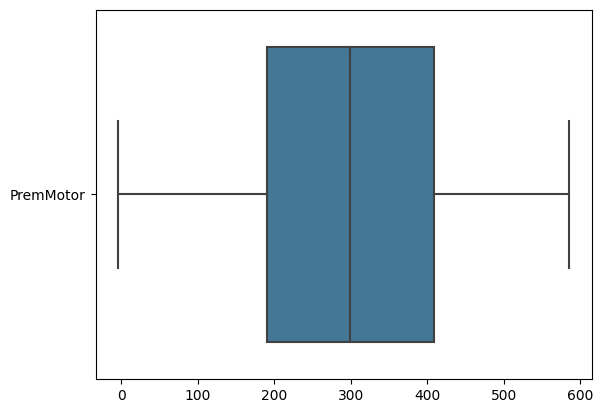

In [36]:
sns.boxplot(data=df[['PremMotor']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

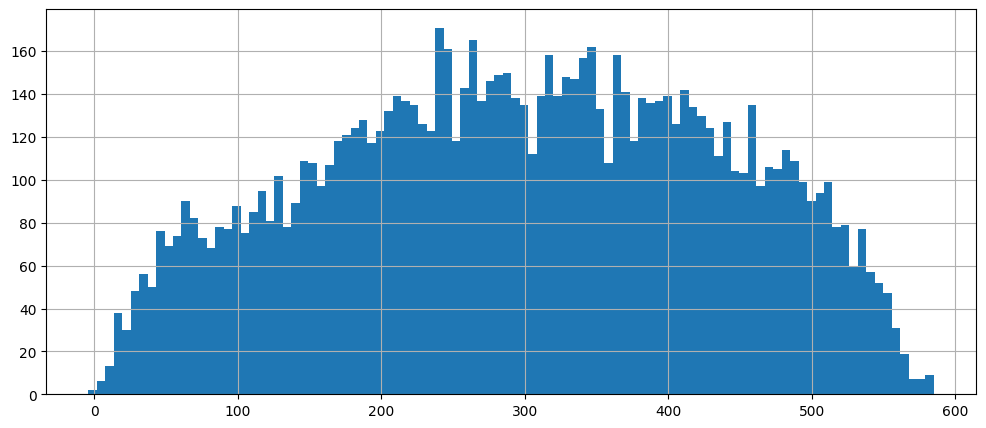

In [37]:
df['PremMotor'].hist(bins=100, figsize=(12,5))

#### PremHousehold

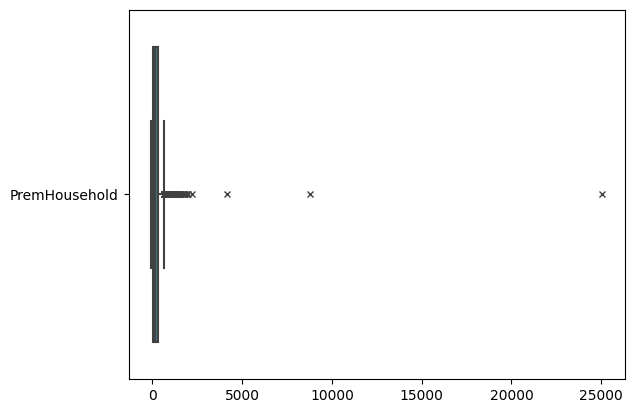

In [38]:
sns.boxplot(data=df[['PremHousehold']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

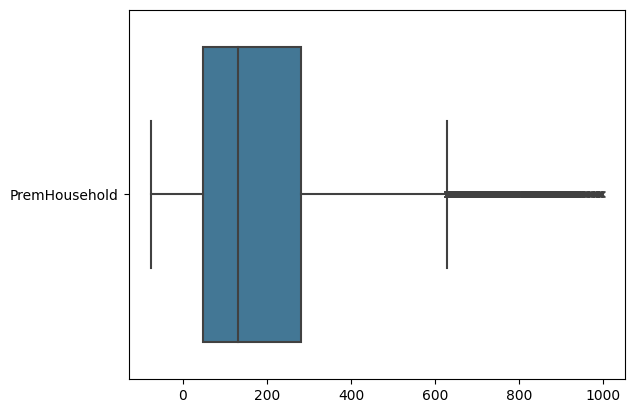

In [39]:
sns.boxplot(data=df[df['PremHousehold'] < 1000][['PremHousehold']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

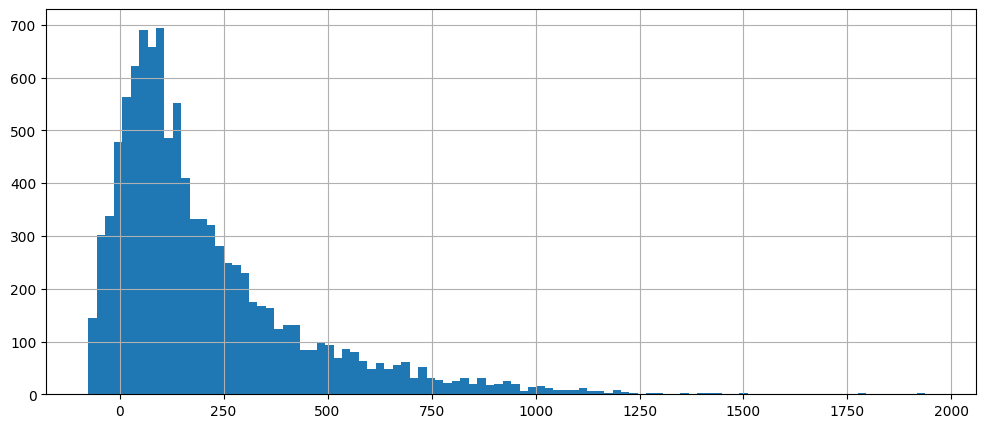

In [40]:
df[df['PremHousehold'] < 2000]['PremHousehold'].hist(bins=100, figsize=(12,5))

In [41]:
print("PremHousehold outliers ", df[df['PremHousehold'] > 1250].shape[0])
df_PremHousehold = df[df['PremHousehold'] < 1250]
PremHousehold_limits = return_tuple_max_min(df_PremHousehold, 'PremHousehold')
df['PremHousehold'] = apply_limits_sup_inf(df, 'PremHousehold', PremHousehold_limits)

PremHousehold outliers  37


<AxesSubplot:>

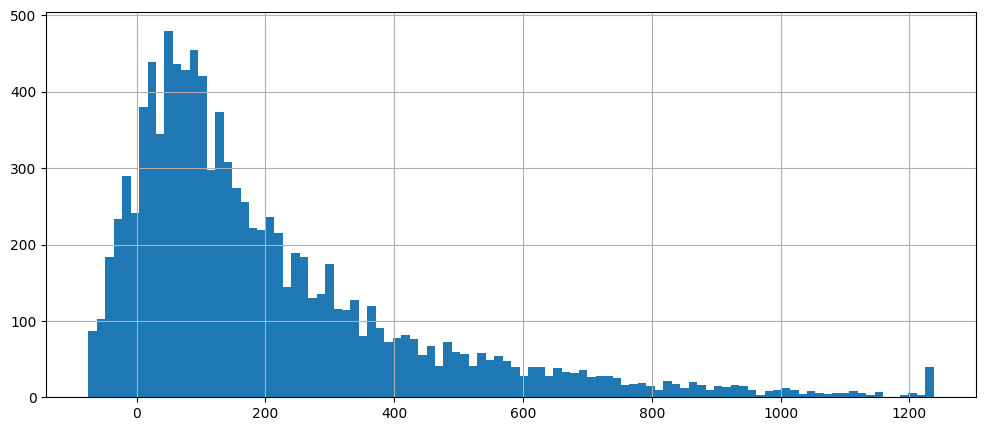

In [42]:
df['PremHousehold'].hist(bins=100, figsize=(12,5))

#### PremHealth

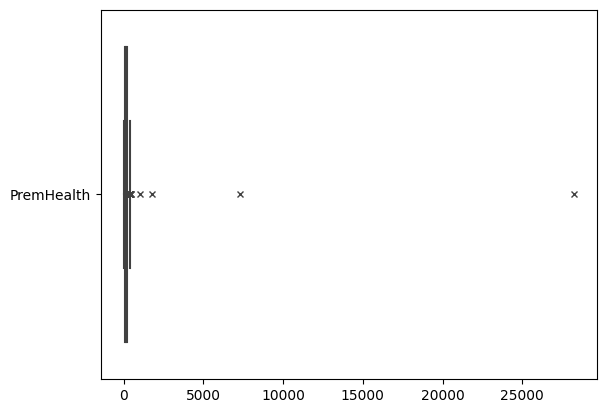

In [43]:
sns.boxplot(data=df[['PremHealth']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

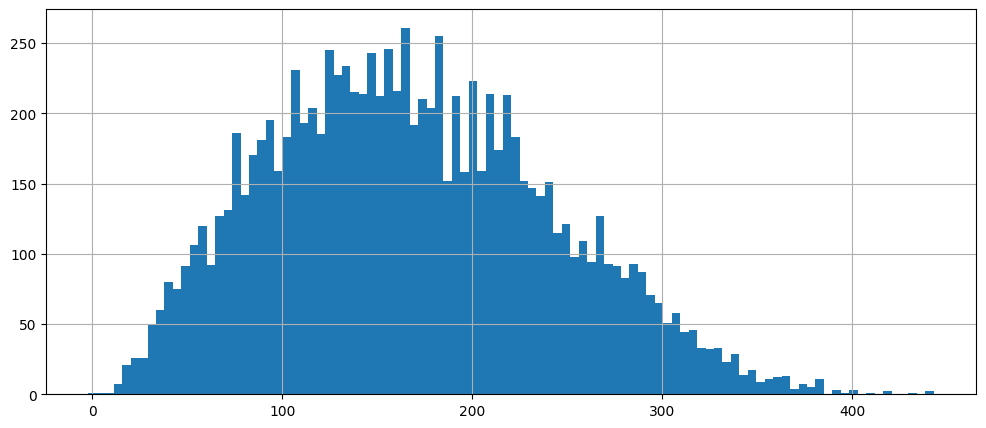

In [44]:
df[df['PremHealth'] < 750]['PremHealth'].hist(bins=100, figsize=(12,5))

In [45]:
df[df['PremHealth'] > 400].shape[0]

11

In [46]:
print("PremHealth outliers ", df[df['PremHealth'] > 400].shape[0])
df_PremHealth = df[df['PremHealth'] < 400]
PremHealth_limits = return_tuple_max_min(df_PremHealth, 'PremHealth')
df['PremHealth'] = apply_limits_sup_inf(df, 'PremHealth', PremHealth_limits)

PremHealth outliers  11


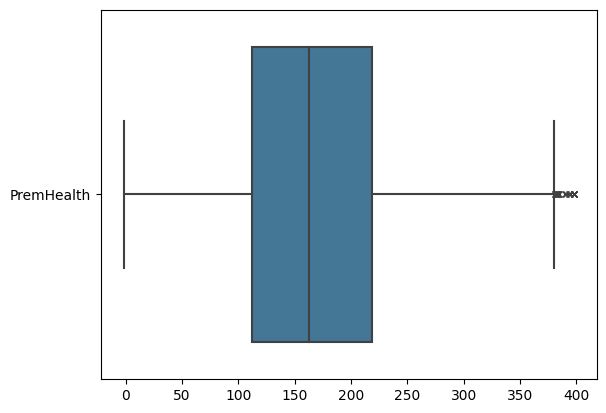

In [47]:
sns.boxplot(data= df[['PremHealth']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

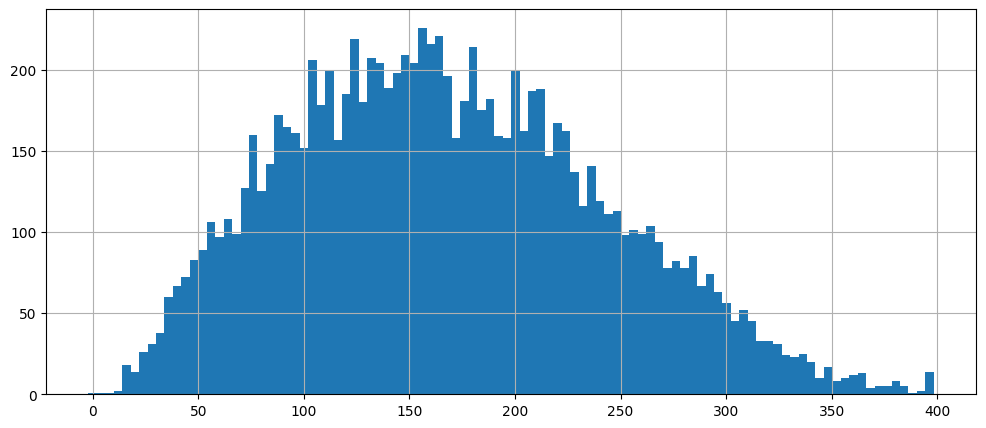

In [48]:
df['PremHealth'].hist(bins=100, figsize=(12,5))

#### PremLife

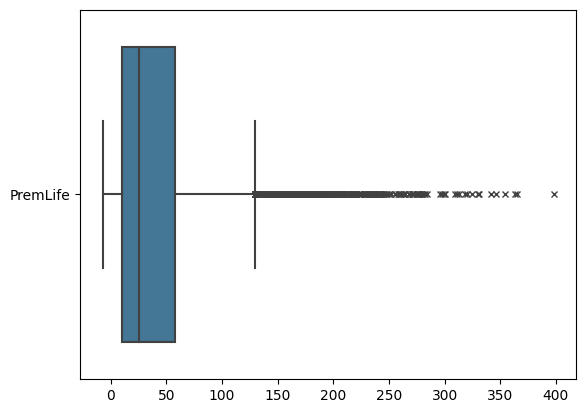

In [49]:
sns.boxplot(data=df[['PremLife']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

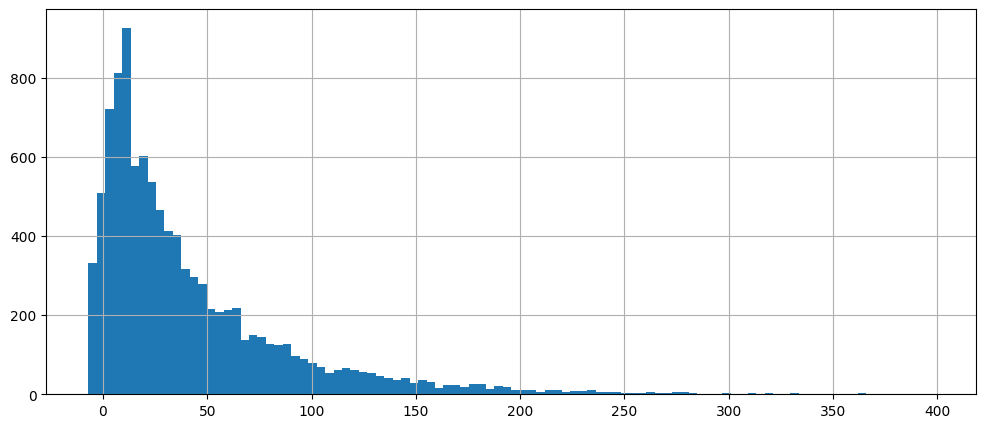

In [50]:
df['PremLife'].hist(bins=100, figsize=(12,5))

In [51]:
df[df['PremLife'] > 250].shape[0]

50

In [52]:
print("PremLife outliers ", df[df['PremLife'] > 250].shape[0])
df_PremLife = df[df['PremLife'] < 250]
PremLife_limits = return_tuple_max_min(df_PremLife, 'PremLife')
df['PremLife'] = apply_limits_sup_inf(df, 'PremLife', PremLife_limits)

PremLife outliers  50


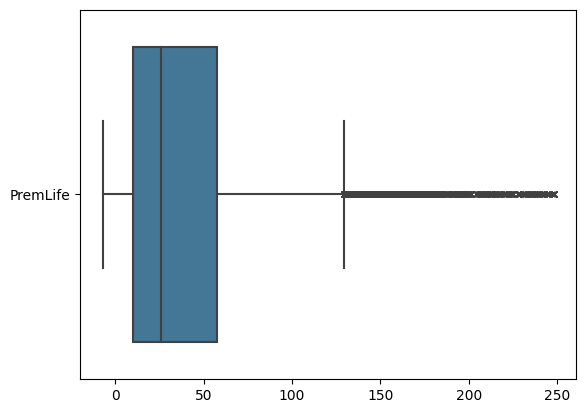

In [53]:
sns.boxplot(data=df[['PremLife']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

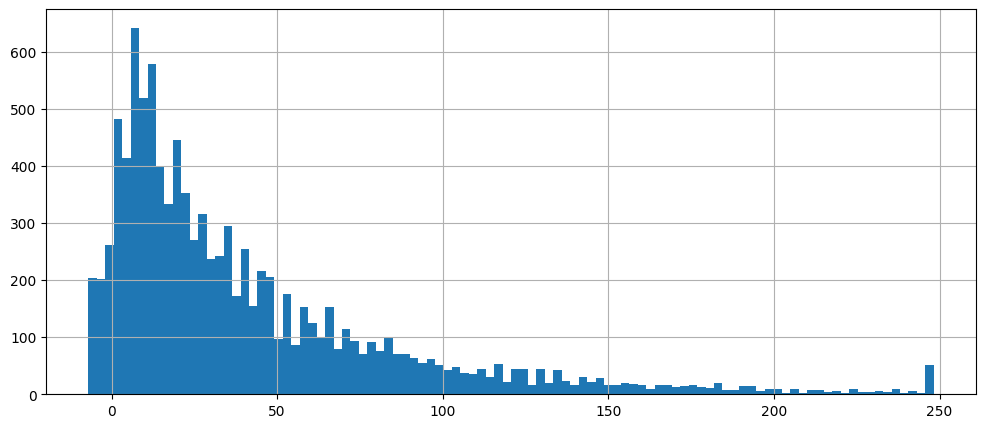

In [54]:
df['PremLife'].hist(bins=100, figsize=(12,5))

#### PremWork

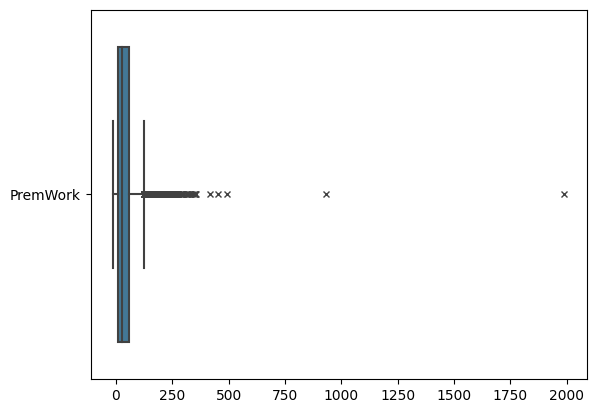

In [55]:
sns.boxplot(data=df[['PremWork']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

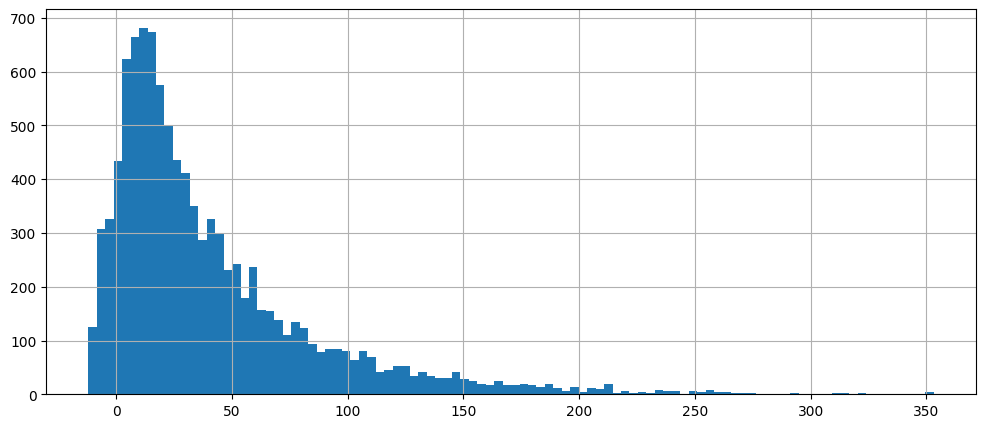

In [56]:
df[df['PremWork'] < 400]['PremWork'].hist(bins=100, figsize=(12,5))

In [57]:
df[df['PremWork'] > 200].shape[0]

145

In [58]:
print("PremWork outliers ", df[df['PremWork'] > 250].shape[0])
df_PremWork = df[df['PremWork'] < 250]
PremWork_limits = return_tuple_max_min(df_PremWork, 'PremWork')
df['PremWork'] = apply_limits_sup_inf(df, 'PremWork', PremWork_limits)

PremWork outliers  55


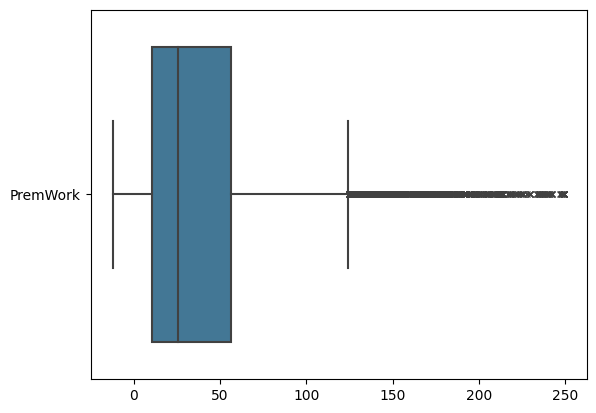

In [59]:
sns.boxplot(data=df[['PremWork']], 
orient="h",
flierprops={"marker": "x"}, 
palette="mako")
plt.show() 

<AxesSubplot:>

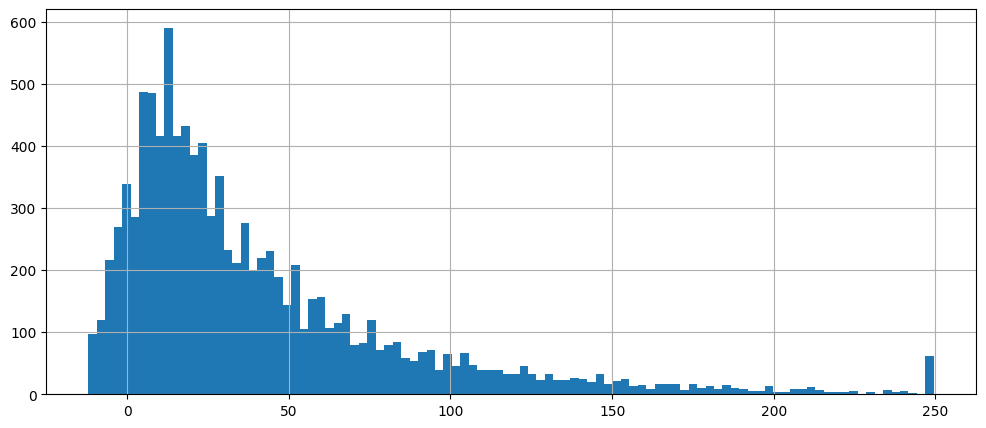

In [60]:
df['PremWork'].hist(bins=100, figsize=(12,5))

### Missing Values

In [61]:
df_treat_nan = df.copy()

In [62]:
numerical_col_list = ['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 
                'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
                'PremLife', 'PremWork']
categorical_col_list = ['EducDeg', 'GeoLivArea','Children'] 
ordinal_col_list = ['EducDeg']
nominal_col_list = ['GeoLivArea','Children']

#### Numerical

In [63]:
nans_index = df_treat_nan.isna().any(axis=1)
df_treat_nan[numerical_col_list][nans_index].head()

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,
69,1983.0,1977.0,1399.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139,1979.0,1976.0,2538.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
185,1993.0,1984.0,2419.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
195,1990.0,1978.0,2349.0,-101.00,1.14,469.31,-65.00,115.80,NaN,11.00
297,NaN,1955.0,3591.0,-49.11,1.04,447.64,-25.00,130.58,0.89,12.89


In [64]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_treat_nan[numerical_col_list] = imputer.fit_transform(df_treat_nan[numerical_col_list])
df_treat_nan.loc[nans_index, numerical_col_list].head()

,FirstPolYear,BirthYear,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,
69,1983.0,1977.0,1399.0,476.65,0.33,330.73,186.70,211.150,33.784,15.78
139,1979.0,1976.0,2538.0,149.59,0.69,194.26,305.60,226.598,37.340,17.67
185,1993.0,1984.0,2419.0,-62.23,1.07,251.87,253.95,230.600,5.890,43.12
195,1990.0,1978.0,2349.0,-101.00,1.14,469.31,-65.00,115.800,11.024,11.00
297,1981.8,1955.0,3591.0,-49.11,1.04,447.64,-25.00,130.580,0.890,12.89


#### Categorical

In [65]:
modes = df_treat_nan[categorical_col_list].mode().loc[0]
modes

EducDeg       3.0
GeoLivArea    4.0
Children      1.0
Name: 0, dtype: float64

In [66]:
df_treat_nan.fillna(modes, inplace=True)
df_treat_nan.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

#### Fix columns type

In [67]:
convert_dict = {'FirstPolYear': int,
                'BirthYear': int,
                'EducDeg': int,
                'GeoLivArea': int,
                'Children': int}
 
df_treat_nan = df_treat_nan.astype(convert_dict) 

### Multivariate

In [68]:
df_to_dbscan = df_treat_nan.copy()

In [69]:
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_to_dbscan)
Counter(dbscan_labels)

Counter({-1: 10253})

In [70]:
df_dbscan_out = df_to_dbscan[dbscan_labels==-1].copy()
df_whithout_outliers = df_to_dbscan[dbscan_labels!=-1].copy()
df_original = df_to_dbscan.copy()


In [71]:
print('Outliers size: ',df_dbscan_out.shape)
print('DF without outliers: ',df_whithout_outliers.shape)
print('Without removing outliers: ',df_original.shape)


Outliers size:  (10253, 13)
DF without outliers:  (0, 13)
Without removing outliers:  (10253, 13)


# Feature Engeneering

## Feature Creation

## Feature Selection

### Correlation

## Final Data

# Models